In [18]:

import keras.utils as utils
import os
import matplotlib.pyplot as plt
directory='Data/Dataset2-Durum Wheat Video Images'

#Data=utils.image_dataset_from_directory(directory)

subdir=os.listdir(directory)

subdir


['1-Images from Vitreous Durum Wheat',
 '2-Images from Starchy Durum Wheat',
 '3-Images from Foreign Matters',
 '4-Images from Mixture of All Durum Wheat and Foreign Matters',
 '5-Images form Mixture of All Durum Wheat and Foreign Matters (Labeled)']

                                          image_name                 label
0  Data/Dataset2-Durum Wheat Video Images/1-Image...  Vitreous_Durum_Wheat
0  Data/Dataset2-Durum Wheat Video Images/1-Image...  Vitreous_Durum_Wheat
0  Data/Dataset2-Durum Wheat Video Images/1-Image...  Vitreous_Durum_Wheat
0  Data/Dataset2-Durum Wheat Video Images/1-Image...  Vitreous_Durum_Wheat
0  Data/Dataset2-Durum Wheat Video Images/1-Image...  Vitreous_Durum_Wheat
(1088, 887, 3)


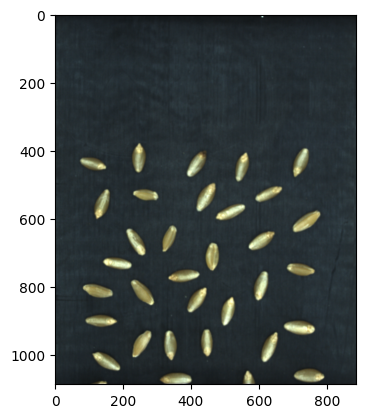

In [19]:
import pandas as pd 
i=0
dir=directory+'/'+subdir[i]

Df=pd.DataFrame()
for file in os.listdir(dir):
    img=utils.load_img(dir+'/'+file)
    img_array=utils.img_to_array(img)
    img_array=img_array.astype(int)
    label='_'.join(subdir[i].split(' ')[2:])
    row=pd.DataFrame(data={"image_name": dir+'/'+file, "label": label},index=[0])
    Df=pd.concat([Df,row])

Df.reset_index()
print(Df.head())



#identify grain in image

print(img_array.shape)
plt.imshow(img_array)



In [20]:
Df

,image_name,label
0,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous_Durum_Wheat
0,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous_Durum_Wheat
0,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous_Durum_Wheat
0,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous_Durum_Wheat
0,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous_Durum_Wheat
...,...,...
0,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous_Durum_Wheat
0,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous_Durum_Wheat
0,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous_Durum_Wheat
0,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous_Durum_Wheat


(1088, 887)


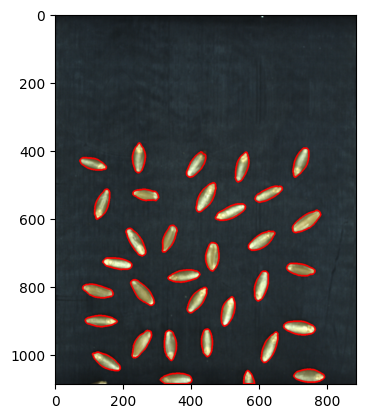

In [21]:
import cv2

# read image

# convert to grayscale
#convert image to 8bits, needed to gray conversion
img_array_8b=cv2.convertScaleAbs(img_array)


img_gray = cv2.cvtColor(img_array_8b,cv2.COLOR_RGB2GRAY)

print(img_gray.shape)
plt.imshow(img_gray)

# threshold
ret,thresh = cv2.threshold(img_gray,60,255,cv2.THRESH_BINARY)

# get contours
result = img_array_8b.copy()
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

clean_contours=[]
for contour in contours:
    area=cv2.contourArea(contour)
    if area> 400: #number of pixel i think
        clean_contours.append(contour)
    
cv2.drawContours(result,clean_contours,-1,(255,0,0),3)
plt.imshow(result)



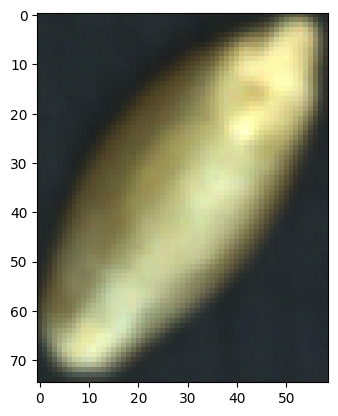

In [22]:
contour=clean_contours[11] #contour is in space of the big image!
x, y, w, h = cv2.boundingRect(contour)
subimg=img_array[y:y+h, x:x+w,:]
plt.imshow(subimg)


('mean', np.float64(104.02598870056497))
('std', np.float64(71.85191930378959))
('skew', np.float64(0.5267537545275217))
('kurtosis', np.float64(-1.2150307898334083))
('entropy', np.float64(6.833281461123726))


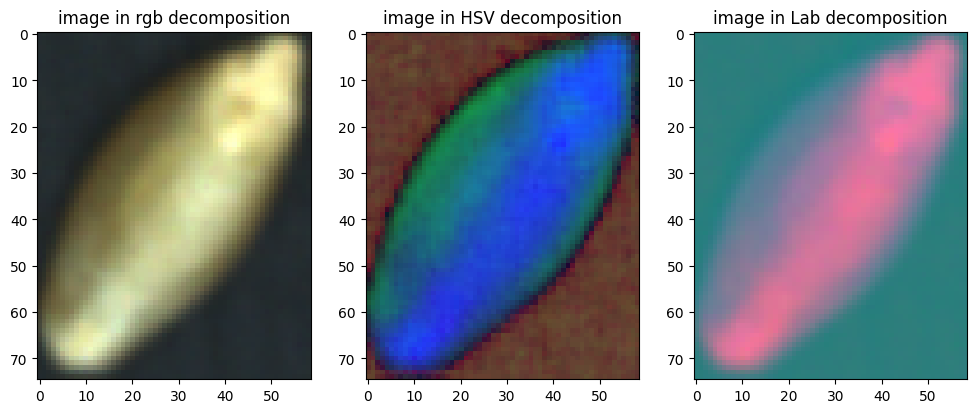

In [23]:
import numpy as np
import scipy.stats as stats




def compute_entropy(image,channel):
    '''
    Entropy of an image for a given color
    '''
    im=image[:,:,channel].flatten()

    #probablity of a pixel havin value x
    proba,_=np.histogram(im,bins=256,range=(0,256))
    proba=proba/len(im)
    
    #remove 0
    proba=[p for p in proba if p!=0]

    #entropy ; # log2 because image is in bits!
    #entropy=stats.entropy(proba,base=2)
    entropy= -np.dot(proba,np.log2(proba))

    return entropy


def color_stats(image,channel):
    '''
    get mean std and skewness for a color(=channel)
    '''
    im=image[:,:,channel].flatten()
    mean=np.mean(im)
    std=np.std(im)
    skew=stats.skew(im)
    kurtosis=stats.kurtosis(im)
    entropy= compute_entropy(image,channel)

    stat_dic=dict()
    stat_dic['mean']=mean
    stat_dic['std']=std
    stat_dic['skew']=skew
    stat_dic['kurtosis']=kurtosis
    stat_dic['entropy']=entropy
    return stat_dic


x, y, w, h = cv2.boundingRect(contour)
subimg_rgb=img_array_8b[y:y+h, x:x+w,:] #cv2 need 8b to convert rgb to hsv
subimg_hsv = cv2.cvtColor(subimg_rgb, cv2.COLOR_RGB2HSV)# hue | saturation | value
subimg_lab = cv2.cvtColor(subimg_rgb,cv2.COLOR_RGB2Lab)# lightness | red/green | yellow/blue
subimg_yrb = cv2.cvtColor(subimg_rgb,cv2.COLOR_RGB2YCrCb)# not sure
    
channel=0
stats_rgb=color_stats(subimg_rgb,channel)# for one color decomposition and for one channel

for item in stats_rgb.items():
  print(item)


fig,ax=plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(subimg_rgb)
ax[0].set_title('image in rgb decomposition')

ax[1].imshow(subimg_hsv)
ax[1].set_title('image in HSV decomposition')

ax[2].imshow(subimg_lab)
ax[2].set_title('image in Lab decomposition')

plt.show()


In [ ]:

def morphological_stats(contour):
    '''
     following definition in the .docx given in 
    'Durum Wheat Dataset Info and Feature Tables.docx'  
    'image is not required!
    'this is for a given subimage (=image centerd on a wheat)
    '''
    data_dic=dict()

    center,axis,angle=cv2.fitEllipse(contour)

    min_axis,maj_axis=axis 
    a=maj_axis/2
    b=min_axis/2
    data_dic['major_axis']=maj_axis
    data_dic['minor_axis']=min_axis


    #number of pixel inside the contour
    #area=cv2.contourArea(contour)
    #area=np.pi*a*b # I prefer this choice,
    x, y, w, h = cv2.boundingRect(contour)
    npixel=0
    for i in range(w):
       for j in range(h):
          test= cv2.pointPolygonTest(contour, (x+i,y+j),False)
          if test==1:
            npixel+=1
    area=npixel        
    data_dic['area']=area


    perimeter=cv2.arcLength(contour,closed=True)
    #perimeter=ellipse_perimeter(a,b) # I prefer this choice,
    data_dic['perimeter']=perimeter


    equivalent_diameter= np.sqrt(area/np.pi)*2#diameter of the 'equivalent' circle
    data_dic['Eq_diamsq']=equivalent_diameter**2


    eccentricity= np.sqrt(1- b**2/a**2)
    data_dic['eccentricity']=eccentricity


    #how closely the shape of an object approchas taht of a circle! ~circularity
    #https://en.wikipedia.org/wiki/Roundness
    #= ratio of the radii of inscribed to circumscribed circles
    # but here formula is different
    roundness= 4*area/np.pi/maj_axis**2
    data_dic['roundness']=roundness


    shape_factor=4*np.pi*area/perimeter**2    #compactness accord to wiki
    data_dic['shape_factor']=shape_factor


    # compactness is shape area/ area of circle with same perimeter
    #https://en.wikipedia.org/wiki/Polsby%E2%80%93Popper_test
    #compactness= (4*np.pi*area)/perimeter**2 
    compactness= np.sqrt(4*area/np.pi)/maj_axis
    data_dic['compactness']=compactness


    #extend is The ratio of pixels in the region to pixels in the total bounding box
    x, y, w, h = cv2.boundingRect(contour)
    #print(w*h)
    extend= area/(w*h)
    data_dic['extend']=extend


    #solidity
    #see https://pmc.ncbi.nlm.nih.gov/articles/PMC4706773/
    hull=cv2.convexHull(contour,returnPoints=True)
    hullarea=cv2.contourArea(hull)
    solidity=area/hullarea
    data_dic['solidity']=solidity


    return data_dic


def ellipse_perimeter(a,b):
    '''
     estimate ellipse perimeter with Ramanujan approximation
     '''
    
    p1= 3*(a+b)
    p2=(3*a+b)*(a+3*b)
    p= np.pi*( p1-np.sqrt(p2) )
    return p


morpho_stats=morphological_stats(contour)
for item in morpho_stats.items():
  print(item)

('major_axis', 85.44928741455078)
('minor_axis', 34.704559326171875)
('area', 2249)
('perimeter', 212.45079052448273)
('Eq_diamsq', np.float64(2863.515736109381))
('eccentricity', np.float64(0.9138099007968921))
('roundness', 0.39217750868675955)
('shape_factor', 0.6261561011172486)
('compactness', np.float64(0.6262407753306707))
('extend', 0.5082485875706215)
('solidity', 0.9410041841004184)


In [25]:
def subimg_colorstats(subimg,decomptype):

    Color_dic=dict()
    for channel in range(3):
        stats=color_stats(subimg,channel)

        for key in list(stats.keys()):
            newname=key+'_'+ decomptype[channel]
            #print(newname,key)
            value=stats.pop(key)
            stats[newname]=value
        
        Color_dic.update(stats)

    return Color_dic    

x, y, w, h = cv2.boundingRect(contour)
subimg_rgb=img_array_8b[y:y+h, x:x+w,:] #cv2 need 8b to convert rgb to hsv
out=subimg_colorstats(subimg_rgb,'RGB')

for item in out.items():
    print(item)

('mean_R', np.float64(104.02598870056497))
('std_R', np.float64(71.85191930378959))
('skew_R', np.float64(0.5267537545275217))
('kurtosis_R', np.float64(-1.2150307898334083))
('entropy_R', np.float64(6.833281461123726))
('mean_G', np.float64(105.74214689265537))
('std_G', np.float64(69.4852694052301))
('skew_G', np.float64(0.6146040360743462))
('kurtosis_G', np.float64(-1.1493825695582933))
('entropy_G', np.float64(6.895434385763404))
('mean_B', np.float64(79.87593220338984))
('std_B', np.float64(45.16994872920262))
('skew_B', np.float64(0.8857403910398257))
('kurtosis_B', np.float64(-0.6718214285365227))
('entropy_B', np.float64(6.554114190217252))


In [26]:


def get_wheatstat_from_image(image):
    ''' 
    get color stats and morphological stats
    '''

    img_array_8b=cv2.convertScaleAbs(img_array)
    img_gray = cv2.cvtColor(img_array_8b,cv2.COLOR_RGB2GRAY)

    # threshold
    ret,thresh = cv2.threshold(img_gray,60,255,cv2.THRESH_BINARY)

    # get contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    clean_contours=[]
    for contour in contours:
        area=cv2.contourArea(contour)
        if area> 100: #number of pixel
            clean_contours.append(contour)
        
    # extraction of small images for a given tif image.
    Df_image=pd.DataFrame()
    i=0
    for contour in clean_contours:
        x, y, w, h = cv2.boundingRect(contour)
        subimg_rgb=img_array_8b[y:y+h, x:x+w,:] #cv2 need 8b to convert rgb to hsv
        subimg_hsv = cv2.cvtColor(subimg_rgb, cv2.COLOR_RGB2HSV)# hue | saturation | value
        subimg_lab = cv2.cvtColor(subimg_rgb,cv2.COLOR_RGB2Lab)# lightness | red/green | yellow/blue
        subimg_yCrCb = cv2.cvtColor(subimg_rgb,cv2.COLOR_RGB2YCrCb)# brightnes |not sure | not sure

        stats_RGB=subimg_colorstats(subimg_rgb,'RGB')
        stats_HSV=subimg_colorstats(subimg_hsv,'HSV')
        stats_LAB=subimg_colorstats(subimg_lab,'Lab')
        stats_YCrCb=subimg_colorstats(subimg_yCrCb,['Y','Cr','Cb'])

        stats_morpho=morphological_stats(contour) #morpho stat is also for a sub image... but morpho depend on contour only

        #stats_wavelet= one day
        #state_gabor = one day

        subimg_stats=stats_RGB | stats_HSV | stats_LAB | stats_YCrCb | stats_morpho

        df_subimage=pd.DataFrame(data=subimg_stats,index=[i])
        Df_image=pd.concat([Df_image,df_subimage])
        i=i+1
        #print(i)

#    Df_image.reset_index(inplace=True)

    return Df_image


Df_image=get_wheatstat_from_image(image=img_array)



print(Df_image.shape)

ll=sorted(list(Df_image.columns))
for l in ll:
    print(l)

        

(34, 71)
Eq_diamsq
area
compactness
eccentricity
entropy_B
entropy_Cb
entropy_Cr
entropy_G
entropy_H
entropy_L
entropy_R
entropy_S
entropy_V
entropy_Y
entropy_a
entropy_b
extend
kurtosis_B
kurtosis_Cb
kurtosis_Cr
kurtosis_G
kurtosis_H
kurtosis_L
kurtosis_R
kurtosis_S
kurtosis_V
kurtosis_Y
kurtosis_a
kurtosis_b
major_axis
mean_B
mean_Cb
mean_Cr
mean_G
mean_H
mean_L
mean_R
mean_S
mean_V
mean_Y
mean_a
mean_b
minor_axis
perimeter
roundness
shape_factor
skew_B
skew_Cb
skew_Cr
skew_G
skew_H
skew_L
skew_R
skew_S
skew_V
skew_Y
skew_a
skew_b
solidity
std_B
std_Cb
std_Cr
std_G
std_H
std_L
std_R
std_S
std_V
std_Y
std_a
std_b


In [27]:
#generalize for all images in a directory
#il faut df_out=(image,label)

Df=pd.DataFrame()

for i in range(3):# consider only the first 3 directories
    dir=directory+'/'+subdir[i]
    
    for file in os.listdir(dir):
        print('beginning analysis of file: ', subdir[i]+'/'+ file)
        img=utils.load_img(dir+'/'+file)
        img_array=utils.img_to_array(img)
        img_array=img_array.astype(int)
        #label='_'.join(subdir[i].split(' '))
        label=subdir[i].split(' ')[2]

        #row=pd.DataFrame(data={"image_name": dir+'/'+file, "label": label},index=[0])
        #Df=pd.concat([Df,row])# Df with image file name and label

        Df_image=get_wheatstat_from_image(image=img_array)
        Df_image['label']=label
        Df_image['file_name']=dir+'/'+file

        Df=pd.concat([Df,Df_image])


Df.reset_index(inplace=True)
del Df['index']




beginning analysis of file:  1-Images from Vitreous Durum Wheat/Frame 0001.tif
beginning analysis of file:  1-Images from Vitreous Durum Wheat/Frame 0002.tif
beginning analysis of file:  1-Images from Vitreous Durum Wheat/Frame 0003.tif
beginning analysis of file:  1-Images from Vitreous Durum Wheat/Frame 0004.tif
beginning analysis of file:  1-Images from Vitreous Durum Wheat/Frame 0005.tif
beginning analysis of file:  1-Images from Vitreous Durum Wheat/Frame 0006.tif
beginning analysis of file:  1-Images from Vitreous Durum Wheat/Frame 0007.tif
beginning analysis of file:  1-Images from Vitreous Durum Wheat/Frame 0008.tif
beginning analysis of file:  1-Images from Vitreous Durum Wheat/Frame 0009.tif
beginning analysis of file:  1-Images from Vitreous Durum Wheat/Frame 0010.tif
beginning analysis of file:  1-Images from Vitreous Durum Wheat/Frame 0011.tif
beginning analysis of file:  1-Images from Vitreous Durum Wheat/Frame 0012.tif
beginning analysis of file:  1-Images from Vitreous 

In [28]:
print(Df.columns)
print(Df.shape)

Df['label'].unique()



Index(['mean_R', 'std_R', 'skew_R', 'kurtosis_R', 'entropy_R', 'mean_G',
       'std_G', 'skew_G', 'kurtosis_G', 'entropy_G', 'mean_B', 'std_B',
       'skew_B', 'kurtosis_B', 'entropy_B', 'mean_H', 'std_H', 'skew_H',
       'kurtosis_H', 'entropy_H', 'mean_S', 'std_S', 'skew_S', 'kurtosis_S',
       'entropy_S', 'mean_V', 'std_V', 'skew_V', 'kurtosis_V', 'entropy_V',
       'mean_L', 'std_L', 'skew_L', 'kurtosis_L', 'entropy_L', 'mean_a',
       'std_a', 'skew_a', 'kurtosis_a', 'entropy_a', 'mean_b', 'std_b',
       'skew_b', 'kurtosis_b', 'entropy_b', 'mean_Y', 'std_Y', 'skew_Y',
       'kurtosis_Y', 'entropy_Y', 'mean_Cr', 'std_Cr', 'skew_Cr',
       'kurtosis_Cr', 'entropy_Cr', 'mean_Cb', 'std_Cb', 'skew_Cb',
       'kurtosis_Cb', 'entropy_Cb', 'major_axis', 'minor_axis', 'area',
       'perimeter', 'Eq_diamsq', 'eccentricity', 'roundness', 'shape_factor',
       'compactness', 'extend', 'solidity', 'label', 'file_name'],
      dtype='object')
(14838, 73)


array(['Vitreous', 'Starchy', 'Foreign'], dtype=object)

In [34]:

Df.to_csv('mywheat_stats.csv')

### Machine learning Classification

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#note : what I call 'label' is called 'Target' in original csv file
X=Df.drop('label',axis=1) 
X=X.drop('file_name',axis=1) # a columns I added because it could be useful somehow, but I don't need it here
y=Df['label']


# transform y before splitting
#y_encoder=OrdinalEncoder()
#Df['Target']=y_encoder.fit_transform(Df)
#print(Df['Target'])

#label encoder is specific for label, Ordinal encoder could apply encoding on hidder features
y_encoder=LabelEncoder()
y=y_encoder.fit_transform(y)
#y=pd.DataFrame(data=y,columns=['label'])

# split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


print(X_train.shape)
#print(y.groupby('label').count())
print(X_train.columns)



(10386, 71)
Index(['mean_R', 'std_R', 'skew_R', 'kurtosis_R', 'entropy_R', 'mean_G',
       'std_G', 'skew_G', 'kurtosis_G', 'entropy_G', 'mean_B', 'std_B',
       'skew_B', 'kurtosis_B', 'entropy_B', 'mean_H', 'std_H', 'skew_H',
       'kurtosis_H', 'entropy_H', 'mean_S', 'std_S', 'skew_S', 'kurtosis_S',
       'entropy_S', 'mean_V', 'std_V', 'skew_V', 'kurtosis_V', 'entropy_V',
       'mean_L', 'std_L', 'skew_L', 'kurtosis_L', 'entropy_L', 'mean_a',
       'std_a', 'skew_a', 'kurtosis_a', 'entropy_a', 'mean_b', 'std_b',
       'skew_b', 'kurtosis_b', 'entropy_b', 'mean_Y', 'std_Y', 'skew_Y',
       'kurtosis_Y', 'entropy_Y', 'mean_Cr', 'std_Cr', 'skew_Cr',
       'kurtosis_Cr', 'entropy_Cr', 'mean_Cb', 'std_Cb', 'skew_Cb',
       'kurtosis_Cb', 'entropy_Cb', 'major_axis', 'minor_axis', 'area',
       'perimeter', 'Eq_diamsq', 'eccentricity', 'roundness', 'shape_factor',
       'compactness', 'extend', 'solidity'],
      dtype='object')


In [30]:
#feature engineering 
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

toencode=X_train.select_dtypes(include=['category','object']).columns

if len(toencode)==0:
    print ('OneHot encoding not needed')



#Both StandardScaler and MinMaxScaler are very sensitive to the presence of outliers.
# as there are a large number of features, I dont want to check outlier for each outlier, -> robust scaler
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)    

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)



# PCA remove mean, but does not apply any scaler... so normalisation is done before
pca=PCA(n_components=10).fit(X_train)

print(pca.explained_variance_ratio_*100)


# COnsider here that some part of the signal is 'noise'. something like 90% is explained -> I take 8 features in PCA space
ncomp=8
percexplained=np.sum(pca.explained_variance_ratio_[:ncomp]*100)
print( str(ncomp) +' features chosen, i.e ' + '{:0.2f}'.format(percexplained) + '% of total variance')


mypca=PCA(n_components=ncomp).fit(X_train)
train_reduced=mypca.transform(X_train)

#### reduce X test too, with same the same operations (SVD decomp and rescaling!)
mypca=PCA(n_components=ncomp).fit(X_test)
test_reduced=mypca.transform(X_test) #PCA! is build on Xtrain!



OneHot encoding not needed
[57.85710276 10.79660898  7.87116589  5.54628975  4.57933516  3.34897868
  2.27861094  1.45492033  1.19967421  1.08437267]
8 features chosen, i.e 93.73% of total variance


In [31]:
from sklearn.preprocessing import MinMaxScaler

# however Xtrain_reduced come from an SVD decomposition which should be is orthogonal
# I am not sure if rescaling remove orthognal properties!
scaler=MinMaxScaler()
X_train_reduced=scaler.fit_transform(train_reduced)
X_test_reduced=scaler.fit_transform(test_reduced)

#transform into dataframe
X_train_reduced=pd.DataFrame(X_train_reduced)
X_test_reduced=pd.DataFrame(X_test_reduced)

          0         1         2         3         4         5         6  \
0  0.001092  0.199630  0.173506  0.091701  0.788799  0.480945  0.429376   
1  0.008852  0.207223  0.166895  0.095799  0.818835  0.481979  0.393089   
2  0.004525  0.196695  0.168613  0.101225  0.798556  0.492085  0.411057   
3  0.006635  0.206473  0.174690  0.094488  0.841487  0.458142  0.414572   
4  0.022939  0.178406  0.163764  0.124403  0.825929  0.476618  0.423313   

          7    target  
0  0.615385   Starchy  
1  0.592297   Starchy  
2  0.619148  Vitreous  
3  0.593113   Foreign  
4  0.641272   Foreign  


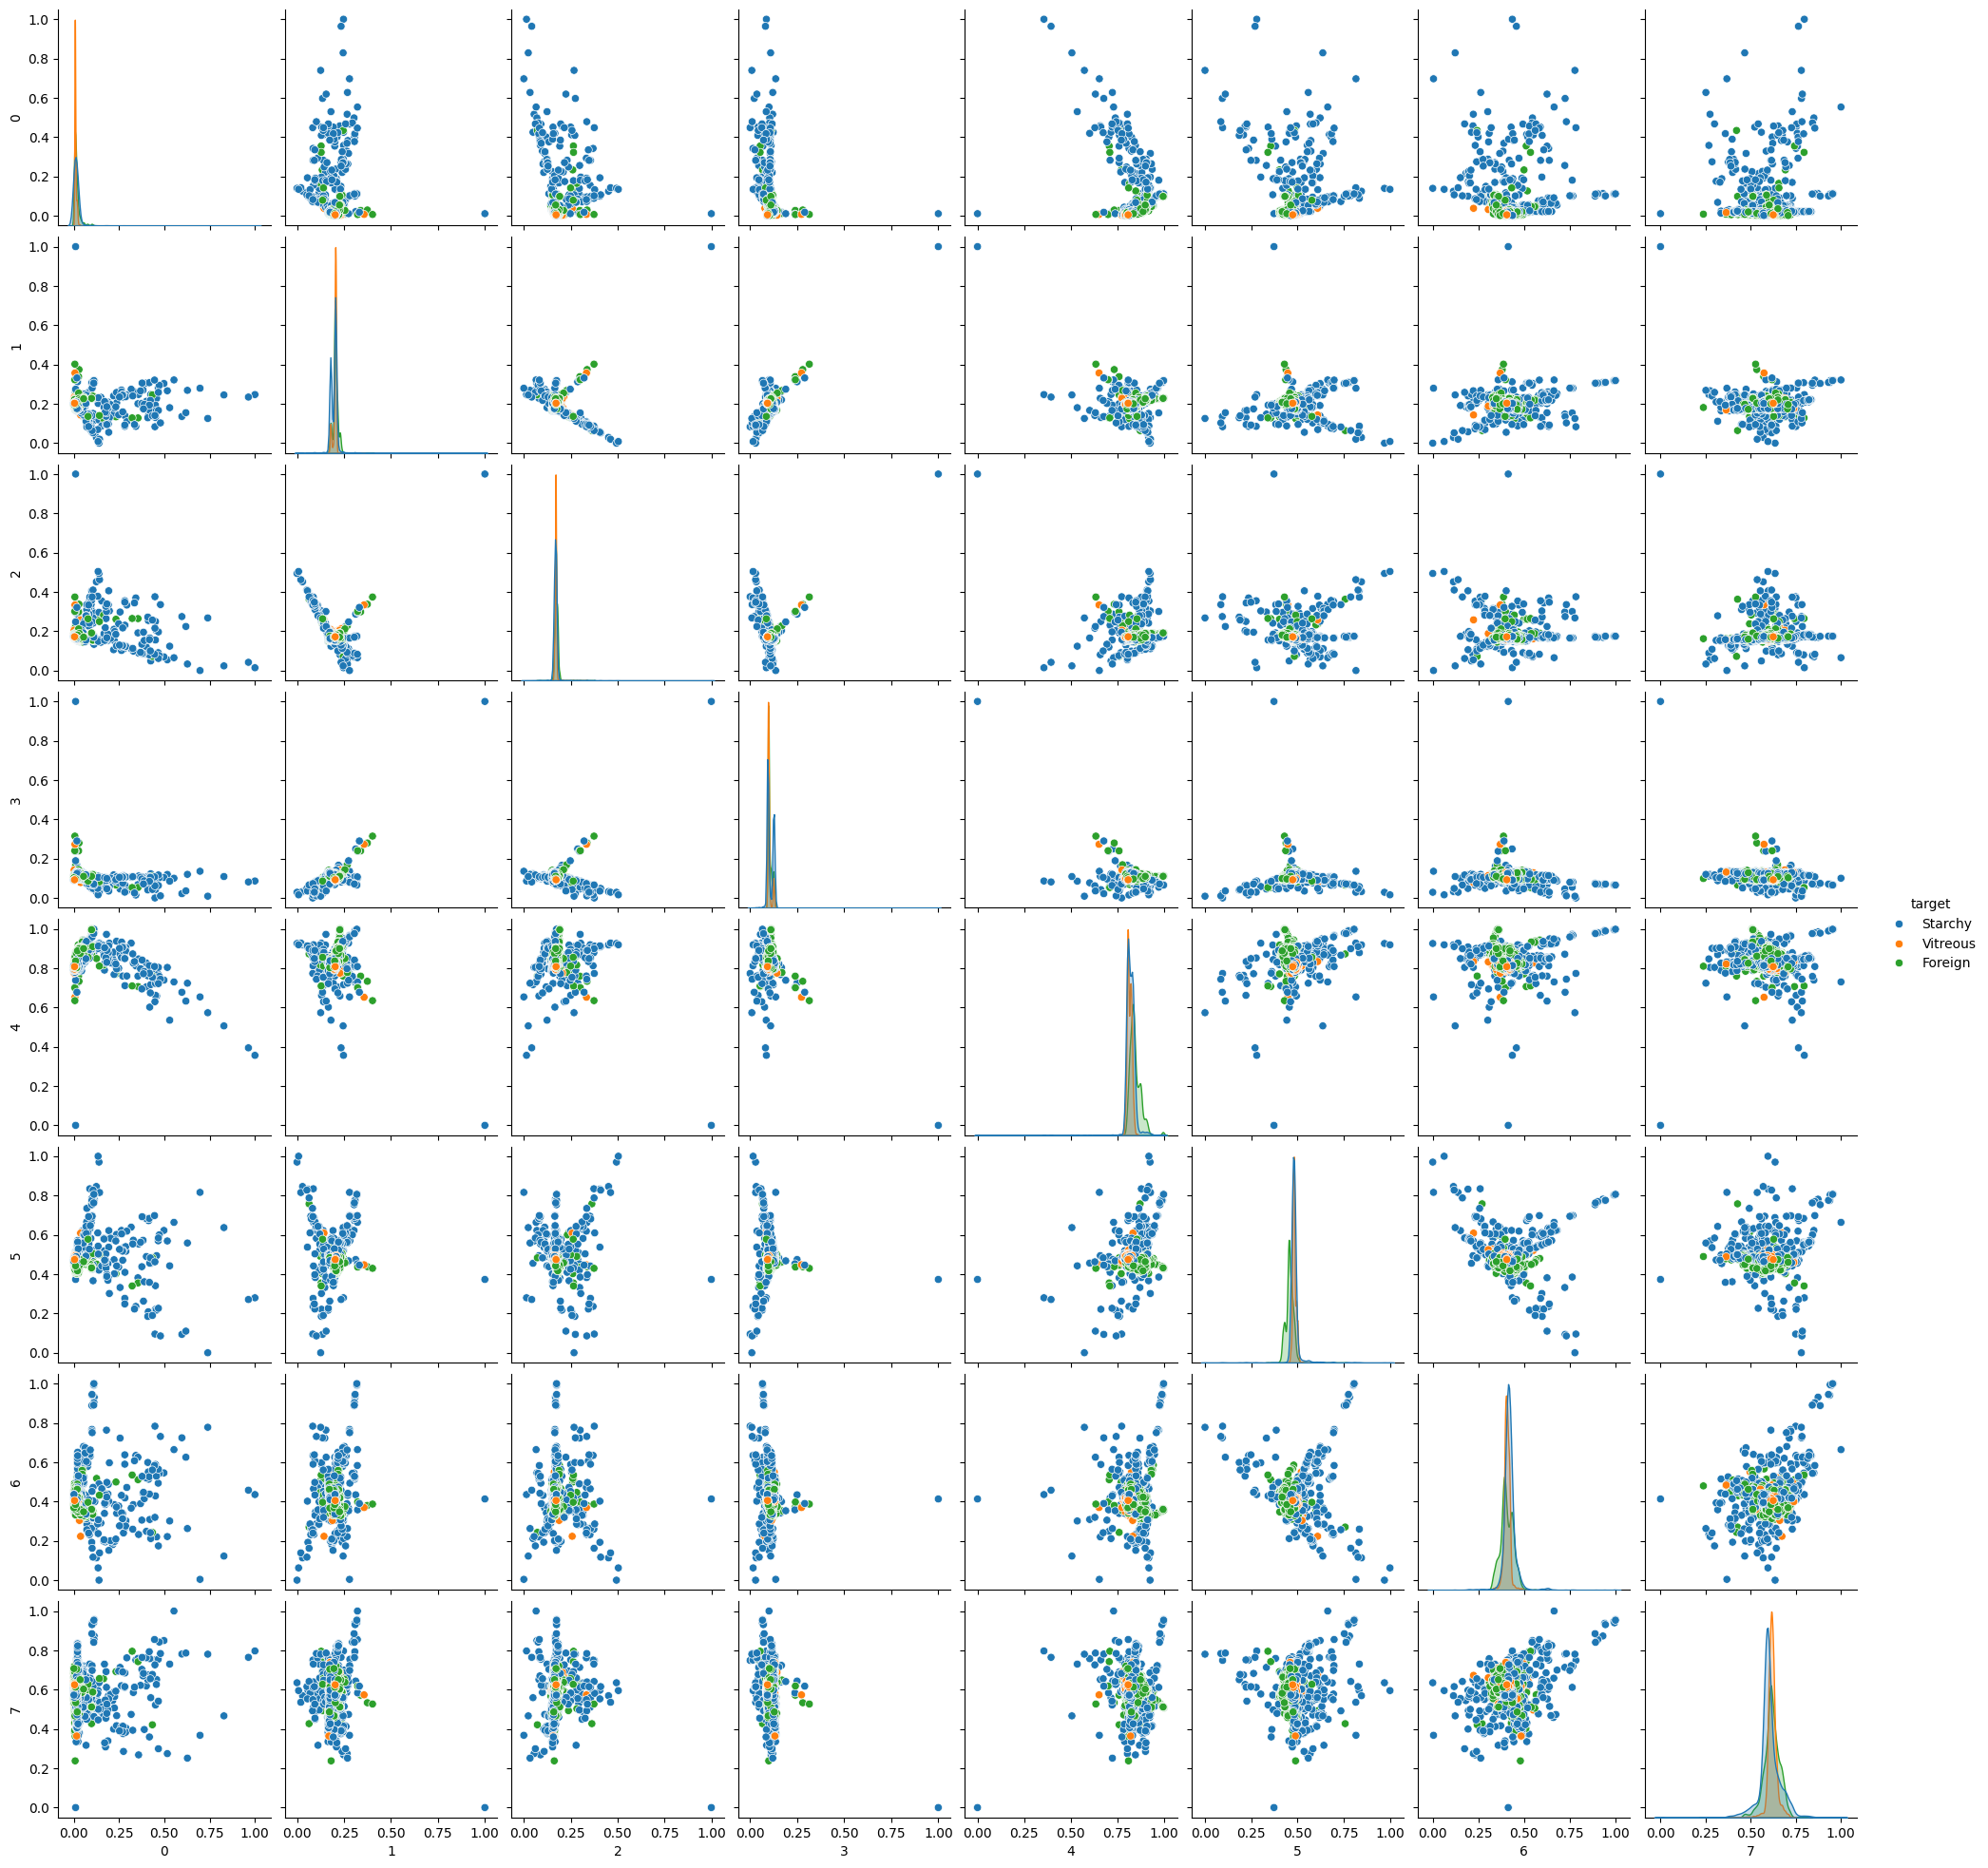

In [32]:
#print(X_train.columns)

import seaborn as sns

#print(df_red)
Z=X_train_reduced.copy()
Z['target']=pd.DataFrame(data=y_encoder.inverse_transform(y_train))
print(Z.head())

sns.pairplot(data=Z,hue='target')

   -----> KNeigh <-----   


c:\Users\juano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\juano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\juano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

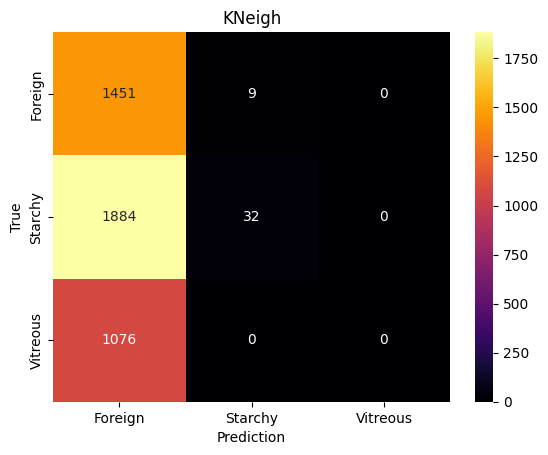

accuracy=33.31
              precision    recall  f1-score   support

     Foreign       0.33      0.99      0.49      1460
     Starchy       0.78      0.02      0.03      1916
    Vitreous       0.00      0.00      0.00      1076

    accuracy                           0.33      4452
   macro avg       0.37      0.34      0.18      4452
weighted avg       0.44      0.33      0.18      4452


 
 

   -----> GradBoost <-----   


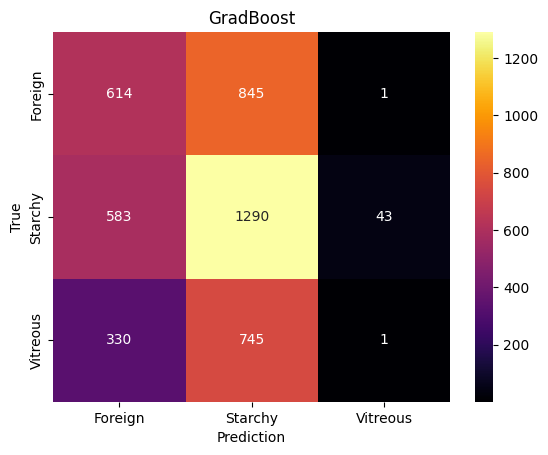

accuracy=42.79
              precision    recall  f1-score   support

     Foreign       0.40      0.42      0.41      1460
     Starchy       0.45      0.67      0.54      1916
    Vitreous       0.02      0.00      0.00      1076

    accuracy                           0.43      4452
   macro avg       0.29      0.36      0.32      4452
weighted avg       0.33      0.43      0.37      4452


 
 

   -----> RandForest <-----   


c:\Users\juano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\juano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\juano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

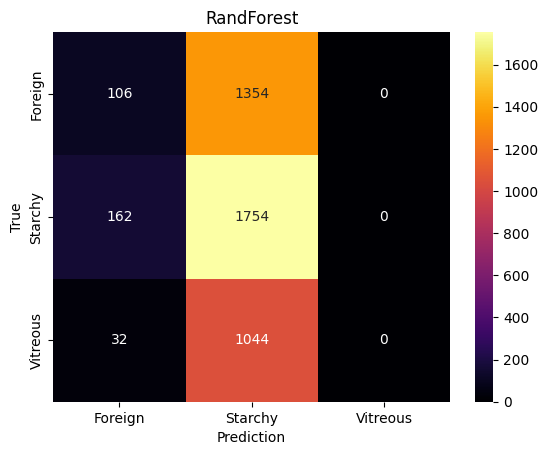

accuracy=41.78
              precision    recall  f1-score   support

     Foreign       0.35      0.07      0.12      1460
     Starchy       0.42      0.92      0.58      1916
    Vitreous       0.00      0.00      0.00      1076

    accuracy                           0.42      4452
   macro avg       0.26      0.33      0.23      4452
weighted avg       0.30      0.42      0.29      4452


 
 



In [33]:
#Model training
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt




ClassifierS={#'MultNB':MultinomialNB(),
            #'GaussNB':GaussianNB(),
            # 'SVC':SVC(random_state=0),#support vector classification
            # 'LogReg':LogisticRegression(random_state=0),
             'KNeigh':KNeighborsClassifier(n_neighbors=3),
            # 'DecTree':DecisionTreeClassifier(random_state=0),
             'GradBoost':GradientBoostingClassifier(random_state=0),
            'RandForest':RandomForestClassifier(random_state=0)
}


classes=y_encoder.inverse_transform(y_test)#.unique()
classes=list(set(classes)) #get unique
classes.sort()

def show_confusion(y_test,y_predict,classes,key):
    '''
    Show confusion matrix and classification error for a given prediction (= classification here)
    '''

    cm = confusion_matrix(y_test, y_predic)
    #fig,ax=plt.subplots(2,3,figsize)
    ax=sns.heatmap(cm,annot=True,cmap='inferno',fmt='g',xticklabels=classes,yticklabels=classes)
    ax.set(xlabel='Prediction',ylabel='True')
    ax.set(title=key)

    acc='{:.2f}'.format(accuracy_score(y_test,y_predic)*100 )  
    report=classification_report(y_test, y_predic,target_names=classes,output_dict=False)

    print('   -----> '+key+' <-----   ')
    plt.show()
    print('accuracy='+acc)
    print(report)
    print('\n \n \n')

    
for key in ClassifierS.keys():
    classifier=ClassifierS[key]

    classifier.fit(X_train_reduced, y_train)
    y_predic=classifier.predict(X_test_reduced)
    
    show_confusion(y_test,y_predic,classes,key)
#fig.show()    
